## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "law_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

Categorical Variables []
Categorical Variables []


In [11]:
dataset_orig.features.shape

(20798, 19)

In [12]:
privileged_groups

[{'gender': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[7. 7. 7. ... 5. 6. 8.]
 [5. 3. 7. ... 6. 6. 7.]
 [8. 6. 7. ... 3. 5. 5.]
 ...
 [3. 3. 7. ... 2. 4. 4.]
 [3. 3. 7. ... 6. 6. 8.]
 [5. 2. 7. ... 5. 5. 5.]]


In [14]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights features                                  \
                                                                           
                                 decile3 decile1 race cluster  lsat ugpa   
instance names                                                             
7609                        1.0      7.0     7.0  7.0     4.0  43.0  3.4   
1121                        1.0      5.0     3.0  7.0     5.0  39.0  3.3   
5346                        1.0      8.0     6.0  7.0     3.0  32.0  3.4   
17844                       1.0      4.0     5.0  7.0     4.0  40.0  3.7   
2961                        1.0      2.0     2.0  7.0     3.0  37.0  2.6   
...                         ...      ...     ...  ...     ...   ...  ...   
19600                       1.0      8.0     6.0  6.0     2.0  33.0  3.0   
17656                       1.0      7.0     7.0  7.0     1.0  39.0  3.8   
17514                       1.0      3.0     3.0  7.0     2.0  30.0  2.8   
3920        

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[3. 2. 3. ... 5. 3. 3.]
 [7. 6. 7. ... 3. 6. 6.]
 [1. 5. 7. ... 5. 6. 7.]
 ...
 [4. 3. 7. ... 4. 6. 7.]
 [4. 5. 7. ... 2. 4. 4.]
 [1. 1. 4. ... 4. 3. 3.]]
no bias type specified
#### Training Dataset shape
(10399, 19)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'race2', 'other', 'asian', 'black', 'hisp', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  5849.0 4550.0
base_pos unpriv:  0.9465934065934066
base_pos priv:  0.9538382629509318
number of favorable labels:  9886
Difference in mean outcomes between unprivileged and privileged groups = -0.007245
#### Train shape, validation shape, 

origin, transf:  10399 11113
after transf priv:  0.9538382629509318
after transf unpriv:  0.9538373860182371
Difference in mean outcomes between unprivileged and privileged groups = -0.000001
[INFO]: training decision tree
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.88      0.45      0.60       513
         1.0       0.97      1.00      0.99     10600

    accuracy                           0.97     11113
   macro avg       0.93      0.72      0.79     11113
weighted avg       0.97      0.97      0.97     11113

Train accuracy:  0.9717448033834248
Validating Original ...
Accuracy for threshold: 0.01  is: 0.9412443504183095
Balanced accuracy is:  0.5397533399044775
Accuracy for threshold: 0.02  is: 0.9412443504183095
Balanced accuracy is:  0.5397533399044775
Accuracy for threshold: 0.03  is: 0.9412443504183095
Balanced accuracy is:  0.5397533399044775
Accuracy for threshold: 0.04  is: 0.9412443504183095
Bal

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.91      0.42      0.57       513
         1.0       0.97      1.00      0.98      9886

    accuracy                           0.97     10399
   macro avg       0.94      0.71      0.78     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.9691316472737763
Validating Original ...
Accuracy for threshold: 0.01  is: 0.9386479469179729
Balanced accuracy is:  0.550959492125391
Accuracy for threshold: 0.02  is: 0.9386479469179729
Balanced accuracy is:  0.550959492125391
Accuracy for threshold: 0.03  is: 0.9386479469179729
Balanced accuracy is:  0.550959492125391
Accuracy for threshold: 0.04  is: 0.9386479469179729
Balanced accuracy is:  0.550959492125391
Accuracy for threshold: 0.05  is: 0.9386479469179729
Balanced accuracy is:  0.550959492125391
Accuracy for threshold: 0.060000000000000005  is: 0.9386479

Accuracy for threshold: 0.17  is: 0.9400903933070488
Balanced accuracy is:  0.5490248616830535
Accuracy for threshold: 0.18000000000000002  is: 0.9400903933070488
Balanced accuracy is:  0.5490248616830535
Accuracy for threshold: 0.19  is: 0.9400903933070488
Balanced accuracy is:  0.5490248616830535
Accuracy for threshold: 0.2  is: 0.9400903933070488
Balanced accuracy is:  0.5490248616830535
Accuracy for threshold: 0.21000000000000002  is: 0.9400903933070488
Balanced accuracy is:  0.5490248616830535
Accuracy for threshold: 0.22  is: 0.9400903933070488
Balanced accuracy is:  0.5490248616830535
Accuracy for threshold: 0.23  is: 0.940475045677469
Balanced accuracy is:  0.5573105196227076
Accuracy for threshold: 0.24000000000000002  is: 0.940475045677469
Balanced accuracy is:  0.5573105196227076
Accuracy for threshold: 0.25  is: 0.940475045677469
Balanced accuracy is:  0.5573105196227076
Accuracy for threshold: 0.26  is: 0.940475045677469
Balanced accuracy is:  0.5573105196227076
Accuracy f

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Type of dataset after EGR: <class 'aif360.algorithms.inprocessing.exponentiated_gradient_reduction.ExponentiatedGradientReduction'>
Attributes of dataset after EGR:
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_params', 'fit', 'fit_predict', 'fit_transform', 'model', 'predict', 'transform']
y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9467256466967978
Balanced accuracy is:  0.5453346478184519
Accuracy for threshold: 0.02  is: 0.9467256466967978
Balanced accuracy is:  0.5453346478184519
Accuracy for threshold: 0.03  is: 0.9467256466967978
Balanced accuracy is:  0.5453346478184519
Accuracy f

Accuracy for threshold: 0.46  is: 0.9387441100105779
Balanced accuracy is:  0.5662781516119806
Accuracy for threshold: 0.47000000000000003  is: 0.9387441100105779
Balanced accuracy is:  0.5662781516119806
Accuracy for threshold: 0.48000000000000004  is: 0.9387441100105779
Balanced accuracy is:  0.5662781516119806
Accuracy for threshold: 0.49  is: 0.9387441100105779
Balanced accuracy is:  0.5662781516119806
Accuracy for threshold: 0.5  is: 0.9370131743436869
Balanced accuracy is:  0.5743476652960552
Best thresh:  0.5
Best balanced accuracy: 0.5743
Corresponding 1-min(DI, 1/DI) value: 0.9914
Corresponding average odds difference value: -0.0196
Corresponding statistical parity difference value: -0.0084
Corresponding equal opportunity difference value: -0.0045
Corresponding Theil index value: 0.0362
Corresponding false positive_rate for privileged: 0.8471
Corresponding false negative_rate for privileged: 0.0201
Corresponding false positive_rate for unpribileged: 0.8125
Corresponding false 

Accuracy for threshold: 0.2  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.21000000000000002  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.22  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.23  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.24000000000000002  is: 0.9415328396961247
Balanced accuracy is:  0.5675718118170516
Accuracy for threshold: 0.25  is: 0.9412443504183095
Balanced accuracy is:  0.5674201281281044
Accuracy for threshold: 0.26  is: 0.9412443504183095
Balanced accuracy is:  0.5674201281281044
Accuracy for threshold: 0.27  is: 0.9412443504183095
Balanced accuracy is:  0.5674201281281044
Accuracy for threshold: 0.28  is: 0.9412443504183095
Balanced accuracy is:  0.5674201281281044
Accuracy for threshold: 0.29000000000000004  is: 0.9412443504183095
Balanced accuracy is:  0.5674201281281044
Accura

Accuracy for threshold: 0.42000000000000004  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.43  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.44  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.45  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.46  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.47000000000000003  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.48000000000000004  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.49  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.5  is: 0.9399942302144437
Balanced accuracy is:  0.5825699579052979
Best thresh:  0.5
Best balanced accuracy: 0.5826
Corresponding 1-min(DI, 1/DI) value: 0.9856
Correspo

Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -2.302585092994046
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.76
  Privacy Risk: 0.71
  Accuracy: 0.71
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.41
  Positive predictive value: 0.74
  Optimal thershold: -2.302585092994046
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.3483066942682157
)
MIA_Result(
  Name: subpopu

Best balanced accuracy: 0.5688
Corresponding 1-min(DI, 1/DI) value: 0.9900
Corresponding average odds difference value: -0.0161
Corresponding statistical parity difference value: -0.0098
Corresponding equal opportunity difference value: -0.0078
Corresponding Theil index value: 0.0332
Corresponding false positive_rate for privileged: 0.8550
Corresponding false negative_rate for privileged: 0.0158
Corresponding false positive_rate for unpribileged: 0.8306
Corresponding false negative_rate for unprivileged: 0.0236
Protected_attr_val, label, 0.0 0.0
Protected_attr_val, label, 0.0 1.0
Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -2.712329858096854
)
MIA_Result(
  Name: entire_dataset_label_0.0
  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Type of dataset after EGR: <class 'aif360.algorithms.inprocessing.exponentiated_gradient_reduction.ExponentiatedGradientReduction'>
Attributes of dataset after EGR:
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_params', 'fit', 'fit_predict', 'fit_transform', 'model', 'predict', 'transform']
y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy for threshold: 0.02  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy for threshold: 0.03  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy f

Accuracy for threshold: 0.45  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.46  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.47000000000000003  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.48000000000000004  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.49  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.5  is: 0.9381671314549476
Balanced accuracy is:  0.5843987873236057
Best thresh:  0.5
Best balanced accuracy: 0.5844
Corresponding 1-min(DI, 1/DI) value: 0.9860
Corresponding average odds difference value: -0.0189
Corresponding statistical parity difference value: -0.0136
Corresponding equal opportunity difference value: -0.0115
Corresponding Theil index value: 0.0367
Corresponding false positive_rate for privileged: 0.8206
Corresponding false negative_rate for pri

Accuracy for threshold: 0.5  is: 0.9377824790845274
Balanced accuracy is:  0.5832667114777956
Best thresh:  0.5
Best balanced accuracy: 0.5833
Corresponding 1-min(DI, 1/DI) value: 0.9844
Corresponding average odds difference value: -0.0290
Corresponding statistical parity difference value: -0.0152
Corresponding equal opportunity difference value: -0.0122
Corresponding Theil index value: 0.0371
Corresponding false positive_rate for privileged: 0.8321
Corresponding false negative_rate for privileged: 0.0183
Corresponding false positive_rate for unpribileged: 0.7863
Corresponding false negative_rate for unprivileged: 0.0305
Testing Original ...
True positive rate is:  0.9763373445242188
True negative rate is:  0.19019607843137254
Balanced accuracy is:  0.5832667114777956
Test Accuracy is:  0.9377824790845274
Best balanced accuracy: 0.5833
Corresponding 1-min(DI, 1/DI) value: 0.9844
Corresponding average odds difference value: -0.0290
Corresponding statistical parity difference value: -0.0

Accuracy for threshold: 0.42000000000000004  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.43  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.44  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.45  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.46  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.47000000000000003  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.48000000000000004  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.49  is: 0.9423983075295701
Balanced accuracy is:  0.5661672010294663
Accuracy for threshold: 0.5  is: 0.9399942302144437
Balanced accuracy is:  0.5825699579052979
Best thresh:  0.5
Best balanced accuracy: 0.5826
Corresponding 1-min(DI, 1/DI) value: 0.9856
Correspo

Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -2.302585092994046
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.76
  Privacy Risk: 0.71
  Accuracy: 0.71
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.41
  Positive predictive value: 0.74
  Optimal thershold: -2.302585092994046
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.3483066942682157
)
MIA_Result(
  Name: subpopu

Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -2.712329858096854
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.74
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.34
  Positive predictive value: 0.76
  Optimal thershold: -2.084845271566609
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.47673451934960737
)
MIA_Result(
  Name: subpop

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Type of dataset after EGR: <class 'aif360.algorithms.inprocessing.exponentiated_gradient_reduction.ExponentiatedGradientReduction'>
Attributes of dataset after EGR:
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_params', 'fit', 'fit_predict', 'fit_transform', 'model', 'predict', 'transform']
y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy for threshold: 0.02  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy for threshold: 0.03  is: 0.9495143763823445
Balanced accuracy is:  0.5382944804982362
Accuracy f

Accuracy for threshold: 0.44  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.45  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.46  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.47000000000000003  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.48000000000000004  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.49  is: 0.9412443504183095
Balanced accuracy is:  0.5757886064730271
Accuracy for threshold: 0.5  is: 0.9381671314549476
Balanced accuracy is:  0.5843987873236057
Best thresh:  0.5
Best balanced accuracy: 0.5844
Corresponding 1-min(DI, 1/DI) value: 0.9860
Corresponding average odds difference value: -0.0189
Corresponding statistical parity difference value: -0.0136
Corresponding equal opportunity difference value: -0.0115
Corresponding Theil index value: 0.0367
Cor

## Display Output

In [18]:
priv_metric_orig_copy = priv_metric_orig

In [19]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 17629.0, 'total_unpriv': 13568.0})

In [20]:
priv_metric_orig

defaultdict(float, {'total_priv': 17629.0, 'total_unpriv': 13568.0})

In [21]:
priv_metric_orig = priv_metric_orig_copy

1)

law_sex
10399
2)

               total_priv  total_unpriv
num_instance                           
orig          5876.333333   4522.666667
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.949578       0.050422    0.954845      0.045155      0.942721   
transf      0.954843       0.045157    0.954845      0.045155      0.954842   

         unpriv_unfavor  
dataset                  
orig           0.057279  
transf         0.045158  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.580395      -0.028682  0.014185      -0.013833   
dt_syn                     0.575790      -0.033188  0.012903      -0.012611   
dt_dir                     0.583736      -0.040790  0.011906      -0.011559   
dt_rew                     0.56642

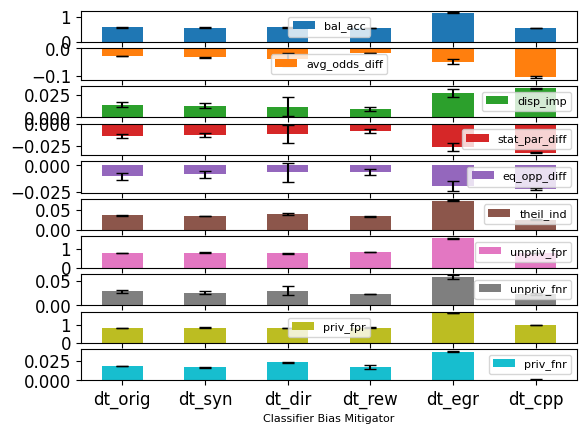

In [22]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

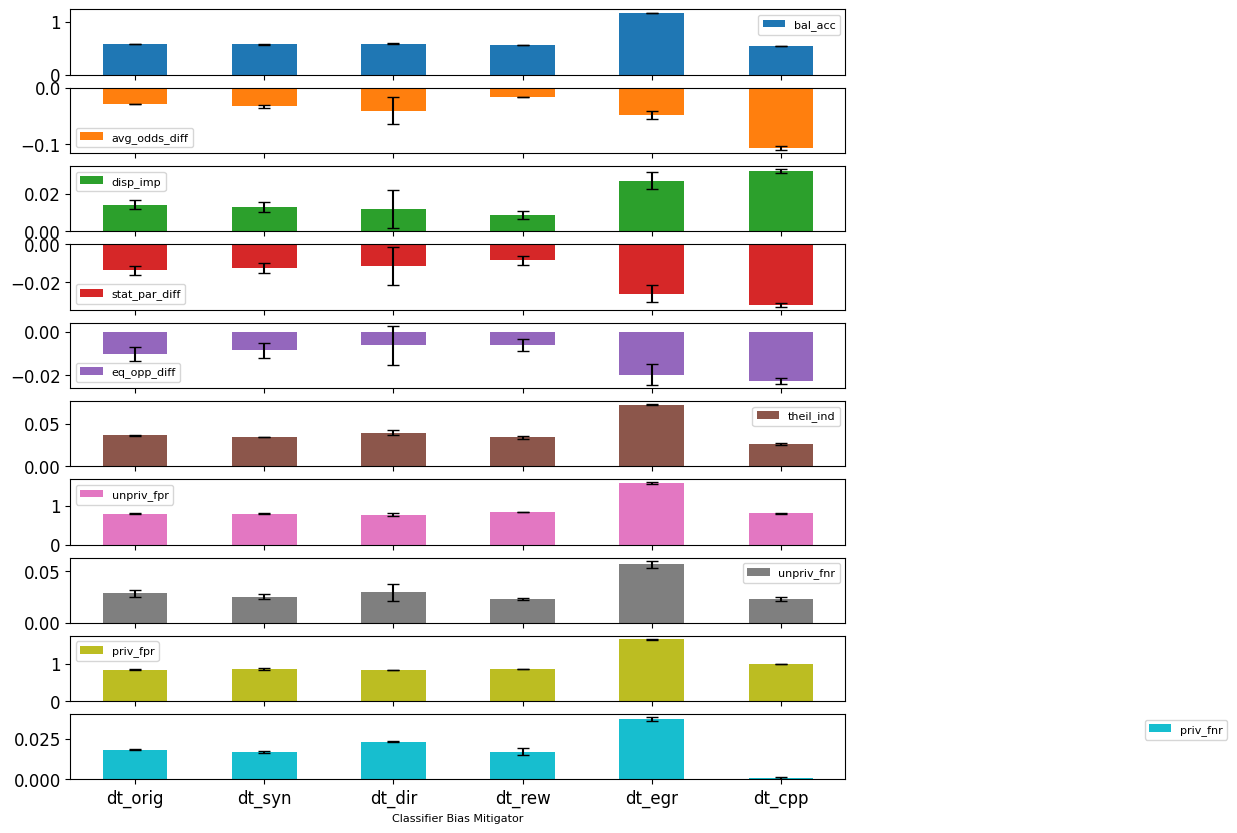

In [23]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [24]:
df

bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.580395      -0.028682  0.014185      -0.013833   
dt_syn                     0.575790      -0.033188  0.012903      -0.012611   
dt_dir                     0.583736      -0.040790  0.011906      -0.011559   
dt_rew                     0.566424      -0.015966  0.008764      -0.008569   
dt_egr                     1.167338      -0.048304  0.026918      -0.026239   
dt_cpp                     0.543147      -0.106559  0.032037      -0.032011   

                           eq_opp_diff  theil_ind  unpriv_fpr  unpriv_fnr  \
Classifier Bias Mitigator                                                   
dt_orig                      -0.010264   0.036578    0.792576    0.028679   
dt_syn                       -0.008550   0.034542    0.798703    0.025458   
dt_dir                       -0.006339   0.039483    0.768145    0.029567   
dt_rew                       -0.006162   0.033993    0.834401    0.023245   
dt_egr                       -0.019825   0.072880    1.580764    0.056888   
dt_cpp                       -0.022667   0.025968    0.807005    0.023391   

                           priv_fpr  priv_fnr  
Classifier Bias Mitigator                      
dt_orig                    0.839675  0.018414  
dt_syn                     0.856528  0.016908  
dt_dir                     0.843387  0.023228  
dt_rew                     0.860171  0.017083  
dt_egr                     1.657546  0.037062  
dt_cpp                     0.997455  0.000724

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [25]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [26]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_privacy_risk  \
Classifier MIA Attacks                                    
orig                                           0.517518   
syn                                            0.515883   
dir                                            0.518992   
rew                                            0.515659   
egr                                            0.517934   

                        entire_dataset_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.696383   
syn                                                      0.668346   
dir                                                      0.697490   
rew                                                      0.675214   
egr                                                      0.693954   

                        entire_dataset_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.510074   
syn                                                      0.510068   
dir                                                      0.512511   
rew                                                      0.509463   
egr                                                      0.509990   

                        subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.681140   
syn                                                         0.670310   
dir                                                         0.686112   
rew                                                         0.660723   
egr                                                         0.682316   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.512860   
syn                                                         0.514740   
dir                                                         0.515727   
rew                                                         0.513092   
egr                                                         0.512477   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.720740   
syn                                                         0.670238   
dir                                                         0.714011   
rew                                                         0.694582   
egr                                                         0.714344   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.508087  
syn                                                         0.507709  
dir                                                         0.512168  
rew                                                         0.507894  
egr                                                         0.508416

In [27]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [28]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [29]:
df_groups

subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.681140   
syn                                                         0.670310   
dir                                                         0.686112   
rew                                                         0.660723   
egr                                                         0.682316   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.512860   
syn                                                         0.514740   
dir                                                         0.515727   
rew                                                         0.513092   
egr                                                         0.512477   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.720740   
syn                                                         0.670238   
dir                                                         0.714011   
rew                                                         0.694582   
egr                                                         0.714344   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.508087  
syn                                                         0.507709  
dir                                                         0.512168  
rew                                                         0.507894  
egr                                                         0.508416

<Axes: xlabel='Classifier MIA Attacks'>

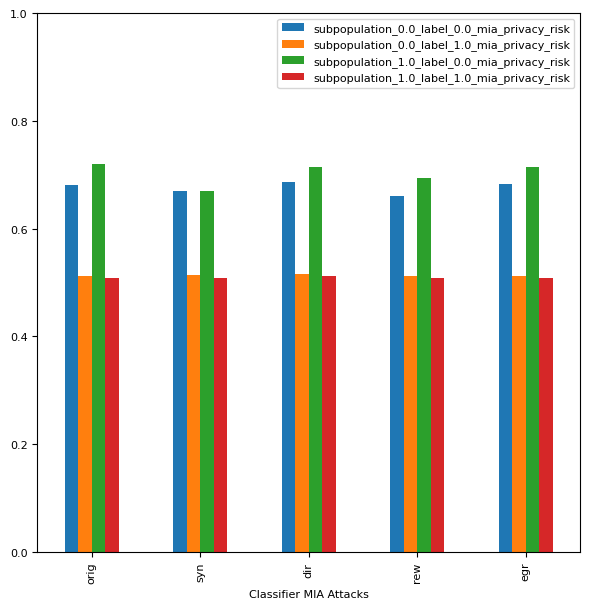

In [30]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [31]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.68114   0.67031   0.686112  0.660723  0.682316
subpopulation_0.0_label_1.0_mia_privacy_risk  0.51286   0.51474   0.515727  0.513092  0.512477
subpopulation_1.0_label_0.0_mia_privacy_risk  0.72074   0.670238  0.714011  0.694582  0.714344
subpopulation_1.0_label_1.0_mia_privacy_risk  0.508087  0.507709  0.512168  0.507894  0.508416


### Visualizing using novel technique

In [32]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [33]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [34]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.516300
1       orig               entire_dataset_mia_privacy_risk      0.518127
2       orig               entire_dataset_mia_privacy_risk      0.518127
3       orig     entire_dataset_label_0.0_mia_privacy_risk      0.669173
4       orig     entire_dataset_label_0.0_mia_privacy_risk      0.709989
..       ...                                           ...           ...
100      egr  subpopulation_1.0_label_0.0_mia_privacy_risk      0.725438
101      egr  subpopulation_1.0_label_0.0_mia_privacy_risk      0.725438
102      egr  subpopulation_1.0_label_1.0_mia_privacy_risk      0.509245
103      egr  subpopulation_1.0_label_1.0_mia_privacy_risk      0.508002
104      egr  subpopulation_1.0_label_1.0_mia_privacy_risk      0.508002

[105 rows x 3 columns]

In [35]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.516300
1       orig               entire_dataset_mia_privacy_risk      0.518127
2       orig               entire_dataset_mia_privacy_risk      0.518127
9       orig  subpopulation_0.0_label_0.0_mia_privacy_risk      0.651507
10      orig  subpopulation_0.0_label_0.0_mia_privacy_risk      0.695957
..       ...                                           ...           ...
100      egr  subpopulation_1.0_label_0.0_mia_privacy_risk      0.725438
101      egr  subpopulation_1.0_label_0.0_mia_privacy_risk      0.725438
102      egr  subpopulation_1.0_label_1.0_mia_privacy_risk      0.509245
103      egr  subpopulation_1.0_label_1.0_mia_privacy_risk      0.508002
104      egr  subpopulation_1.0_label_1.0_mia_privacy_risk      0.508002

[75 rows x 3 columns]

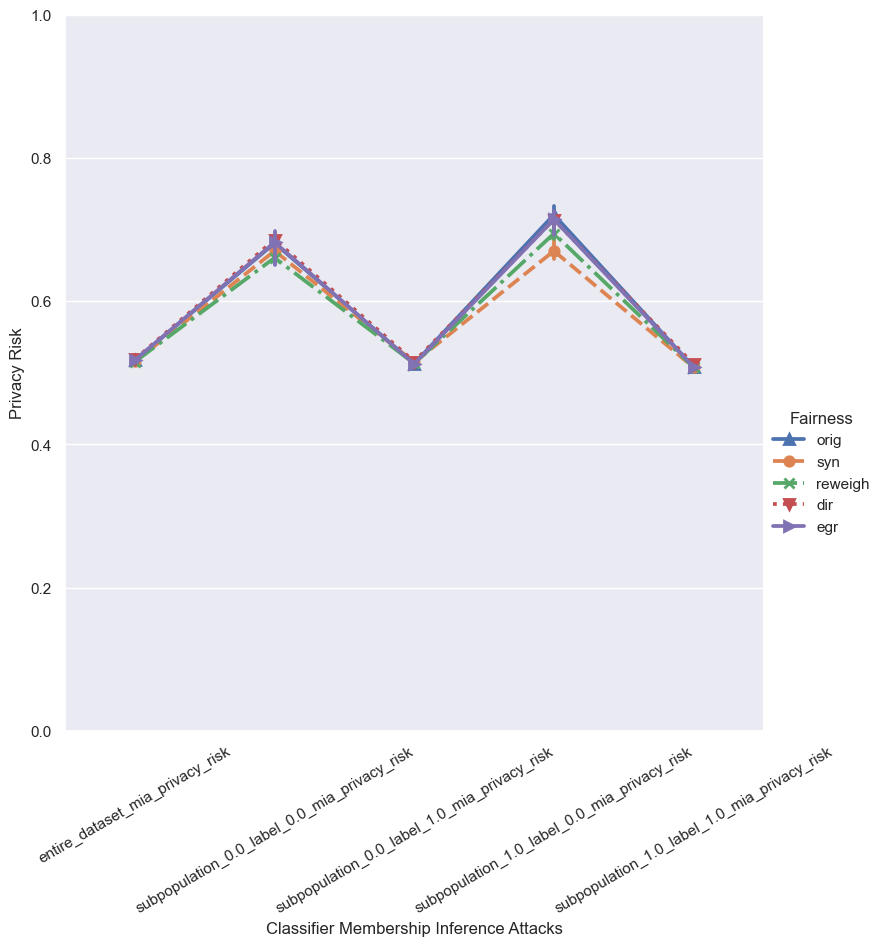

In [40]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [41]:
from sklearn.metrics import RocCurveDisplay, auc

In [42]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

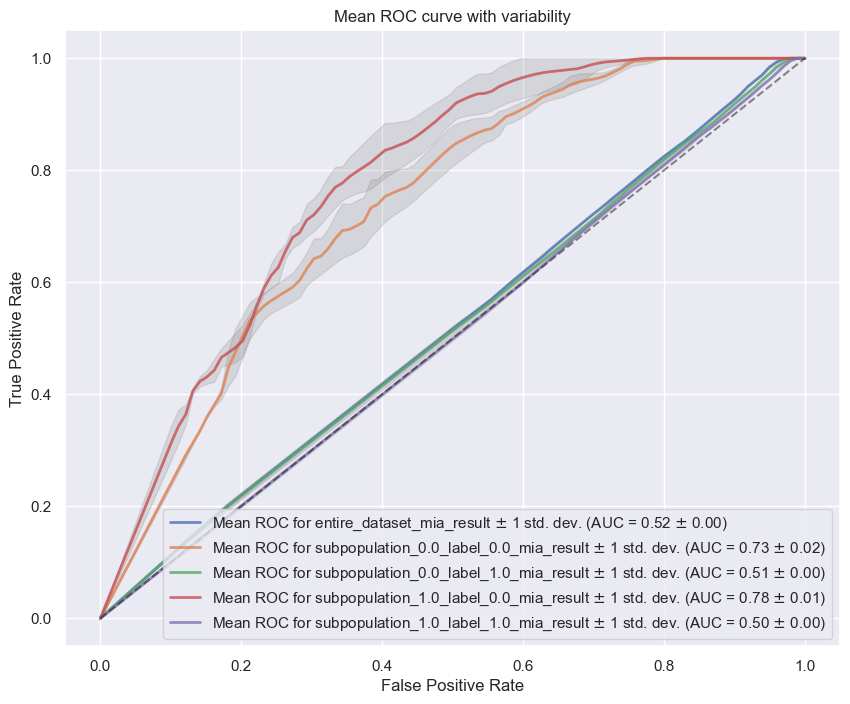

In [43]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

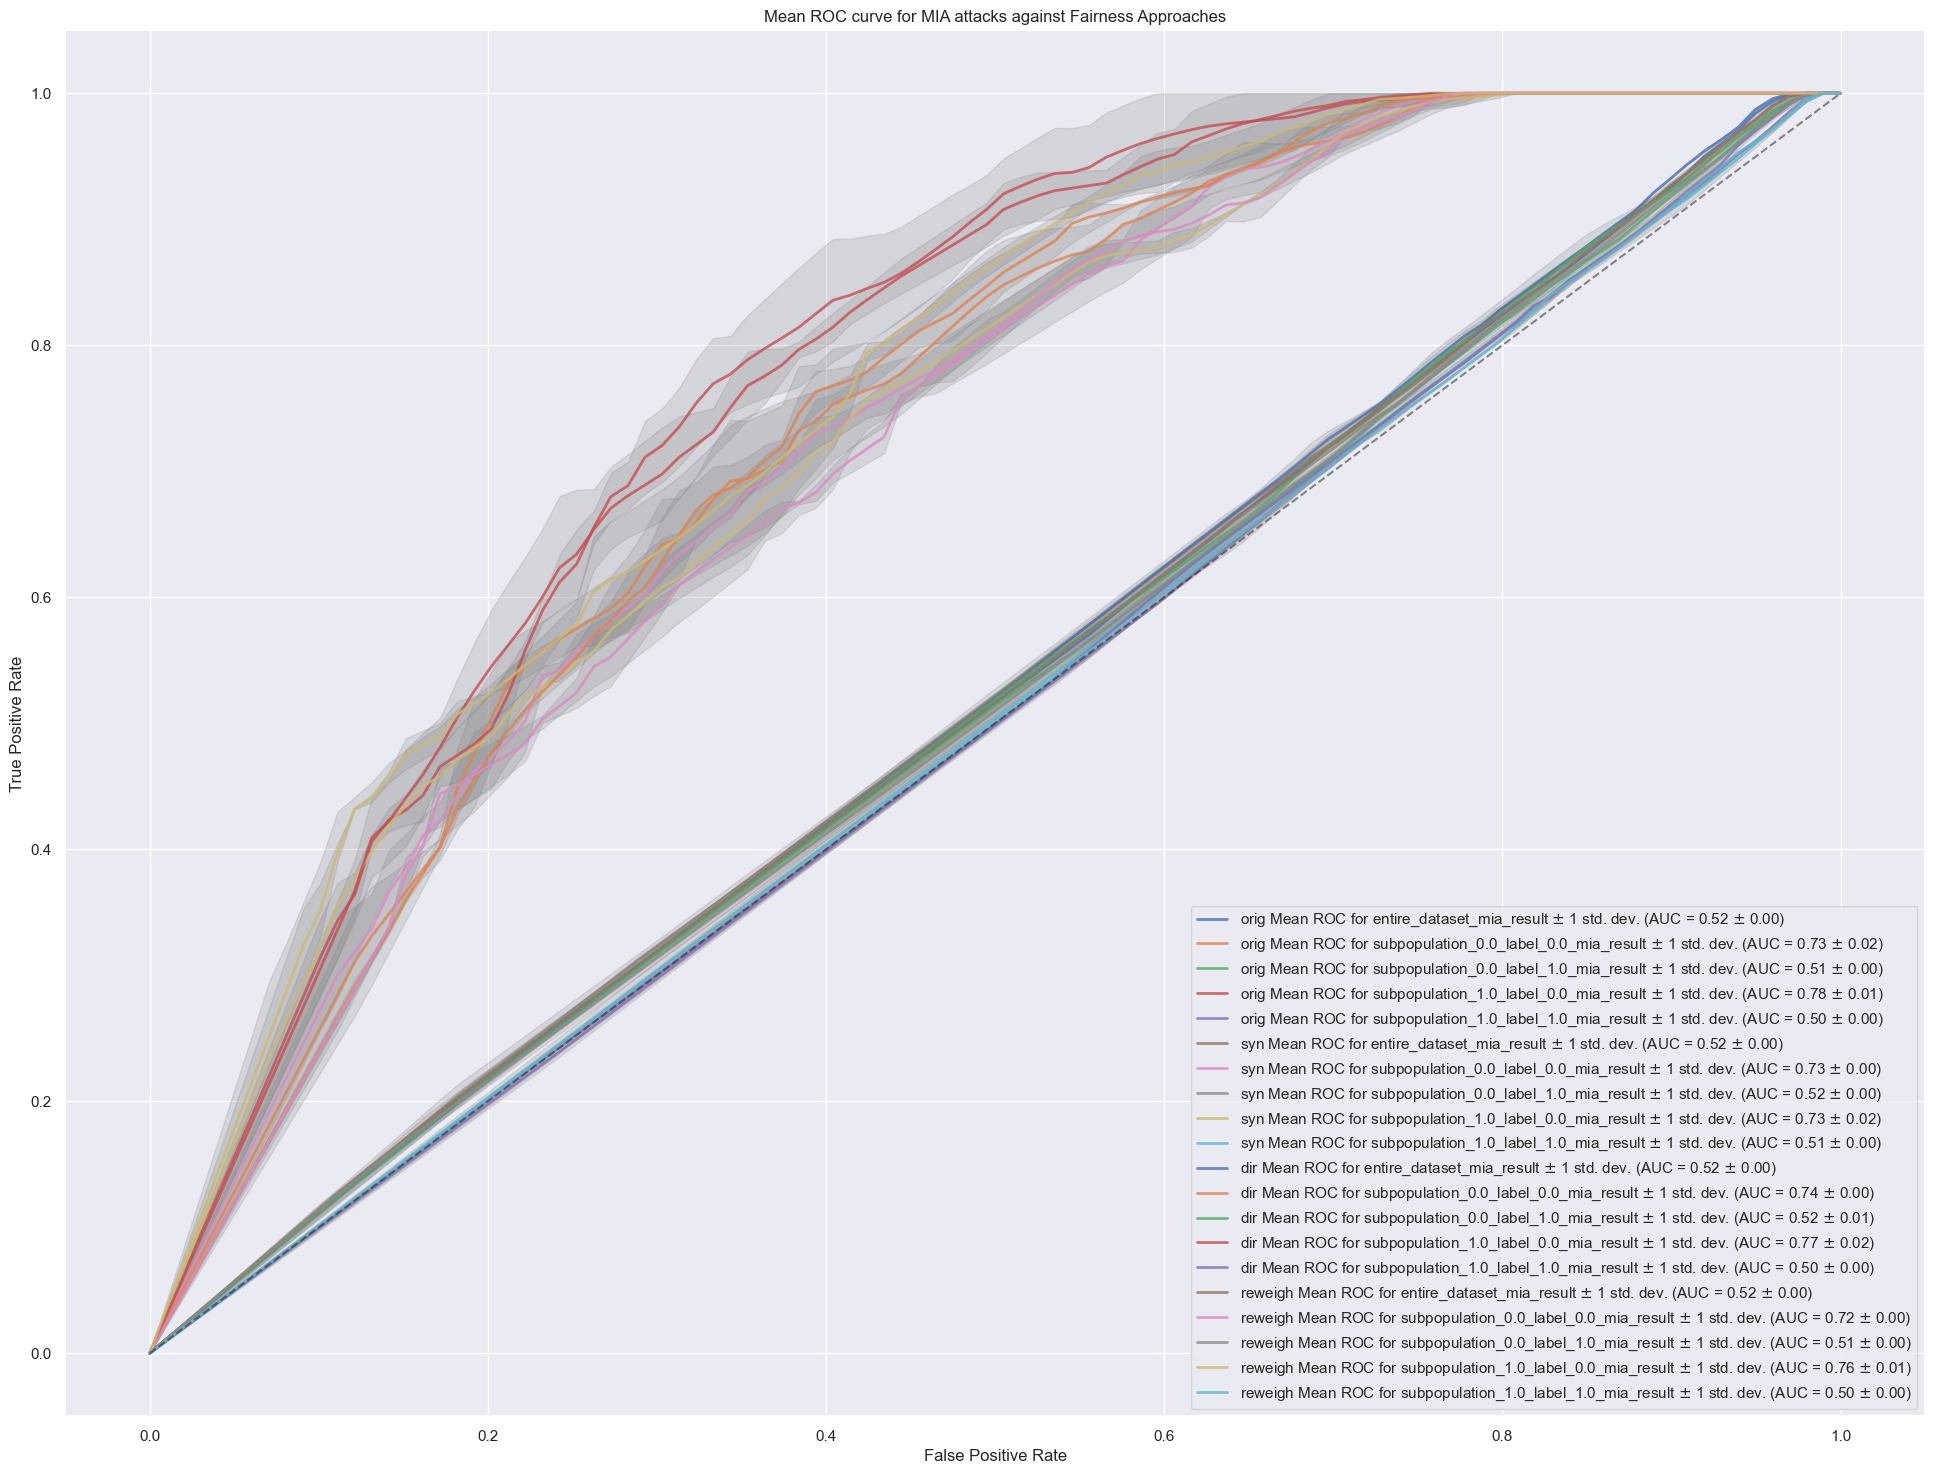

In [44]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

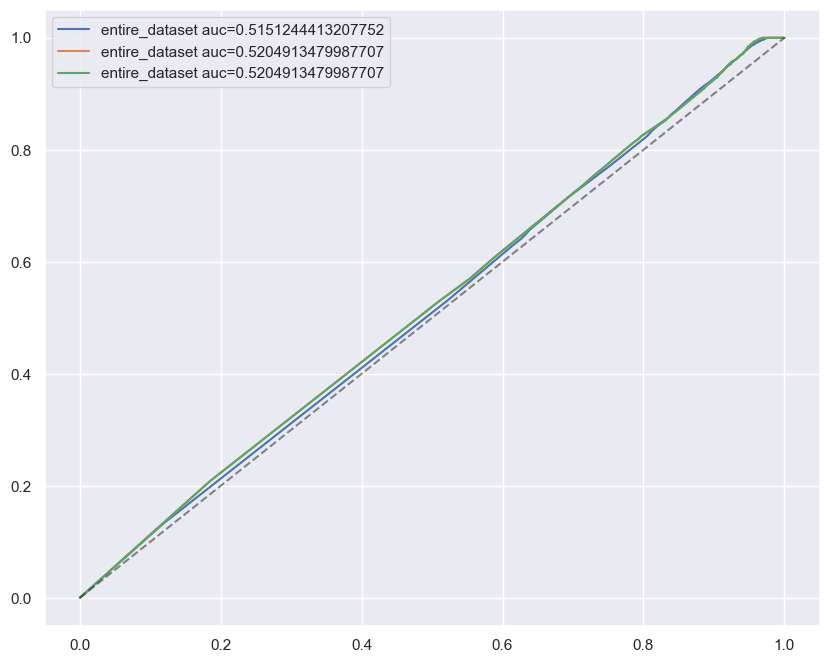

In [45]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [46]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [47]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5187023791061055,
 'entire_dataset_label_0.0_mia_auc': 0.7548408829527903,
 'entire_dataset_label_1.0_mia_auc': 0.5085209761992774,
 'subpopulation_0.0_label_0.0_mia_auc': 0.7336037629261242,
 'subpopulation_0.0_label_1.0_mia_auc': 0.5146228422198208,
 'subpopulation_1.0_label_0.0_mia_auc': 0.7760379435024443,
 'subpopulation_1.0_label_1.0_mia_auc': 0.5032840493132048}

In [48]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_auc  \
Classifier MIA Attacks                           
orig                                  0.518702   
syn                                   0.520996   
dir                                   0.521098   
rew                                   0.519007   

                        entire_dataset_label_0.0_mia_auc  \
Classifier MIA Attacks                                     
orig                                            0.754841   
syn                                             0.730721   
dir                                             0.754546   
rew                                             0.738785   

                        entire_dataset_label_1.0_mia_auc  \
Classifier MIA Attacks                                     
orig                                            0.508521   
syn                                             0.511308   
dir                                             0.510433   
rew                                             0.508770   

                        subpopulation_0.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.733604   
syn                                                0.728474   
dir                                                0.737348   
rew                                                0.717493   

                        subpopulation_0.0_label_1.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.514623   
syn                                                0.518861   
dir                                                0.518074   
rew                                                0.513982   

                        subpopulation_1.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.776038   
syn                                                0.732829   
dir                                                0.772572   
rew                                                0.758047   

                        subpopulation_1.0_label_1.0_mia_auc  
Classifier MIA Attacks                                       
orig                                               0.503284  
syn                                                0.505478  
dir                                                0.504062  
rew                                                0.504457

<Axes: xlabel='Classifier MIA Attacks'>

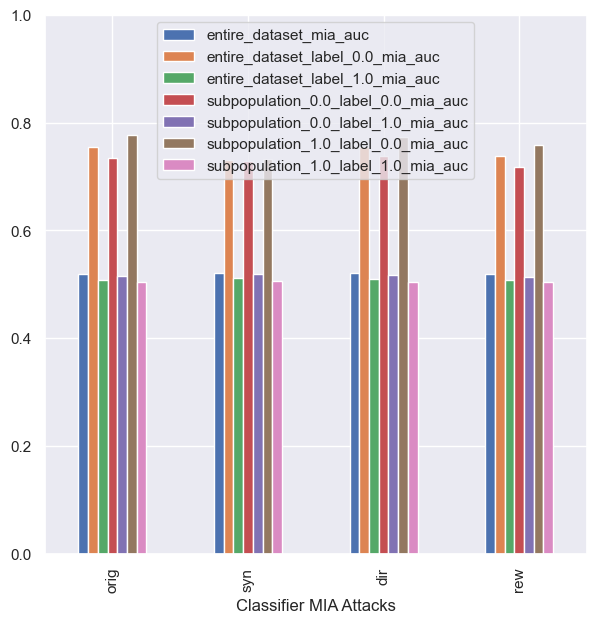

In [49]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [50]:
# Creating data structures to plot point categorical plot from seaborn

In [51]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [52]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.03259928839311477,
  0.036253485912106864,
  0.036253485912106864],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.33834533624806273,
  0.41997780244173144,
  0.41997780244173144],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.01884575735507965,
  0.020800487191184214,
  0.020800487191184214],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.3030137981118374,
  0.3919143409447868,
  0.3919143409447868],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.022640670764791593,
  0.027258877317612007,
  0.027258877317612007],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.392156862745098,
  0.4661422807883203,
  0.4661422807883203],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.01651717957006571,
  0.01600364451663283,
  0.01600364451663283]}

In [53]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.03259928839311477],
 ['orig', 'entire_dataset', 0.036253485912106864],
 ['orig', 'entire_dataset', 0.036253485912106864],
 ['orig', 'entire_dataset_label_0.0', 0.33834533624806273],
 ['orig', 'entire_dataset_label_0.0', 0.41997780244173144],
 ['orig', 'entire_dataset_label_0.0', 0.41997780244173144],
 ['orig', 'entire_dataset_label_1.0', 0.01884575735507965],
 ['orig', 'entire_dataset_label_1.0', 0.020800487191184214],
 ['orig', 'entire_dataset_label_1.0', 0.020800487191184214],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3030137981118374],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3919143409447868],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3919143409447868],
 ['orig', 'subpopulation_0.0_label_1.0', 0.022640670764791593],
 ['orig', 'subpopulation_0.0_label_1.0', 0.027258877317612007],
 ['orig', 'subpopulation_0.0_label_1.0', 0.027258877317612007],
 ['orig', 'subpopulation_1.0_label_0.0', 0.392156862745098],
 ['orig', 'subpopulation_1.0_label_0.0', 0.4661

In [54]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

Fairness                          MIA  attacker_advantage
0       orig               entire_dataset            0.032599
1       orig               entire_dataset            0.036253
2       orig               entire_dataset            0.036253
3       orig     entire_dataset_label_0.0            0.338345
4       orig     entire_dataset_label_0.0            0.419978
..       ...                          ...                 ...
100      egr  subpopulation_1.0_label_0.0            0.450875
101      egr  subpopulation_1.0_label_0.0            0.450875
102      egr  subpopulation_1.0_label_1.0            0.018491
103      egr  subpopulation_1.0_label_1.0            0.016004
104      egr  subpopulation_1.0_label_1.0            0.016004

[105 rows x 3 columns]

KeyError: 'egr'

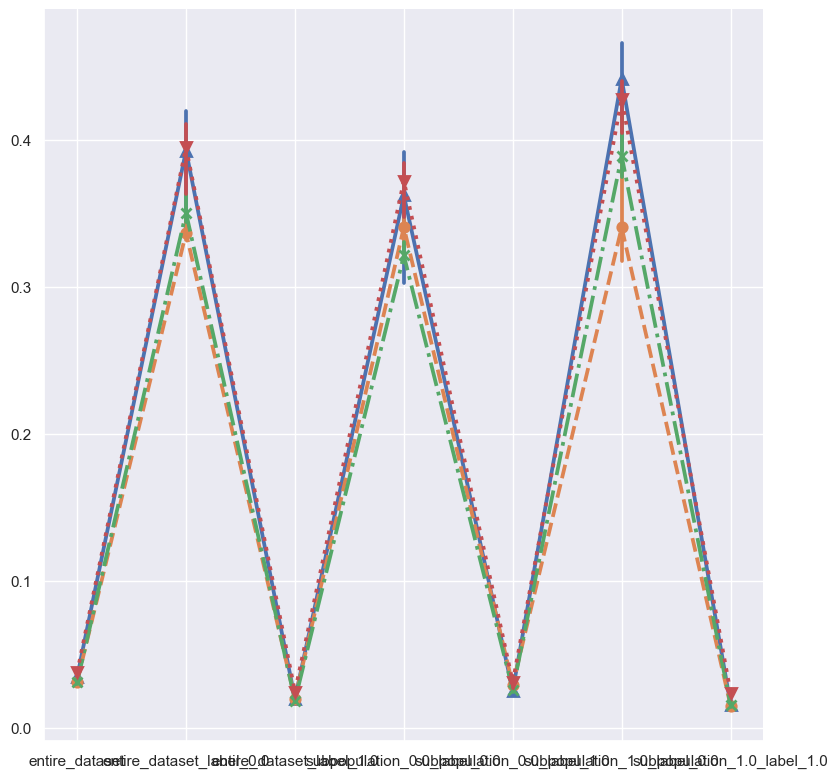

In [55]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [56]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_auc  \
Classifier MIA Attacks                           
orig                                  0.518702   
syn                                   0.520996   
dir                                   0.521098   
rew                                   0.519007   
egr                                        NaN   

                        entire_dataset_label_0.0_mia_auc  \
Classifier MIA Attacks                                     
orig                                            0.754841   
syn                                             0.730721   
dir                                             0.754546   
rew                                             0.738785   
egr                                                  NaN   

                        entire_dataset_label_1.0_mia_auc  \
Classifier MIA Attacks                                     
orig                                            0.508521   
syn                                             0.511308   
dir                                             0.510433   
rew                                             0.508770   
egr                                                  NaN   

                        subpopulation_0.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.733604   
syn                                                0.728474   
dir                                                0.737348   
rew                                                0.717493   
egr                                                     NaN   

                        subpopulation_0.0_label_1.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.514623   
syn                                                0.518861   
dir                                                0.518074   
rew                                                0.513982   
egr                                                     NaN   

                        subpopulation_1.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.776038   
syn                                                0.732829   
dir                                                0.772572   
rew                                                0.758047   
egr                                                     NaN   

                        subpopulation_1.0_label_1.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.503284   
syn                                                0.505478   
dir                                                0.504062   
rew                                                0.504457   
egr                                                     NaN   

                        entire_dataset_mia_privacy_risk  \
Classifier MIA Attacks                                    
orig                                                NaN   
syn                                                 NaN   
dir                                                 NaN   
rew                                                 NaN   
egr                                            0.517934   

                        entire_dataset_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                          NaN   
syn                                                           NaN   
dir                                                           NaN   
rew                                                           NaN   
egr                                                      0.693954   

                        entire_dataset_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                       

<Axes: xlabel='Classifier MIA Attacks'>

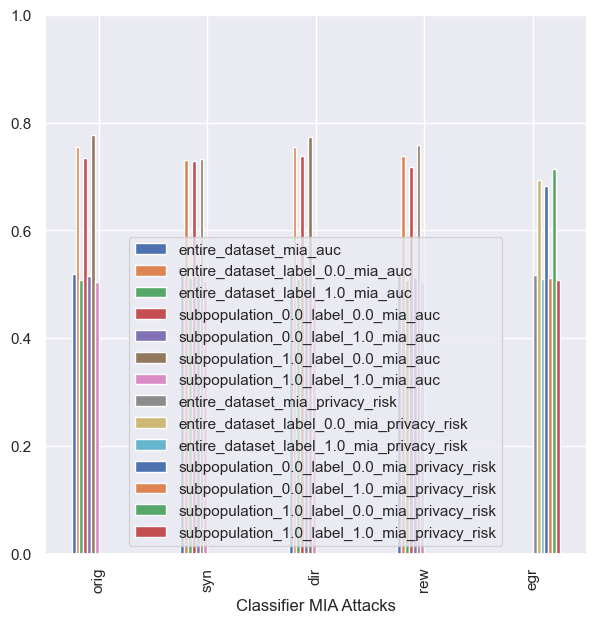

In [57]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [58]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [59]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5278422273781902],
 ['orig', 'entire_dataset', 0.5300171526586621],
 ['orig', 'entire_dataset', 0.5300171526586621],
 ['orig', 'entire_dataset_label_0.0', 0.7412280701754386],
 ['orig', 'entire_dataset_label_0.0', 0.7417218543046357],
 ['orig', 'entire_dataset_label_0.0', 0.7417218543046357],
 ['orig', 'entire_dataset_label_1.0', 0.5072094995759118],
 ['orig', 'entire_dataset_label_1.0', 0.5155018392012612],
 ['orig', 'entire_dataset_label_1.0', 0.5155018392012612],
 ['orig', 'subpopulation_0.0_label_0.0', 0.6880733944954128],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7401129943502825],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7401129943502825],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5224153705397987],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5266311584553928],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5266311584553928],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7899159663865546],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7553956834532375],
 ['

In [60]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

Fairness                          MIA       PPV
0       orig               entire_dataset  0.527842
1       orig               entire_dataset  0.530017
2       orig               entire_dataset  0.530017
3       orig     entire_dataset_label_0.0  0.741228
4       orig     entire_dataset_label_0.0  0.741722
..       ...                          ...       ...
100      egr  subpopulation_1.0_label_0.0  0.748148
101      egr  subpopulation_1.0_label_0.0  0.748148
102      egr  subpopulation_1.0_label_1.0  0.505536
103      egr  subpopulation_1.0_label_1.0  0.509770
104      egr  subpopulation_1.0_label_1.0  0.509770

[105 rows x 3 columns]

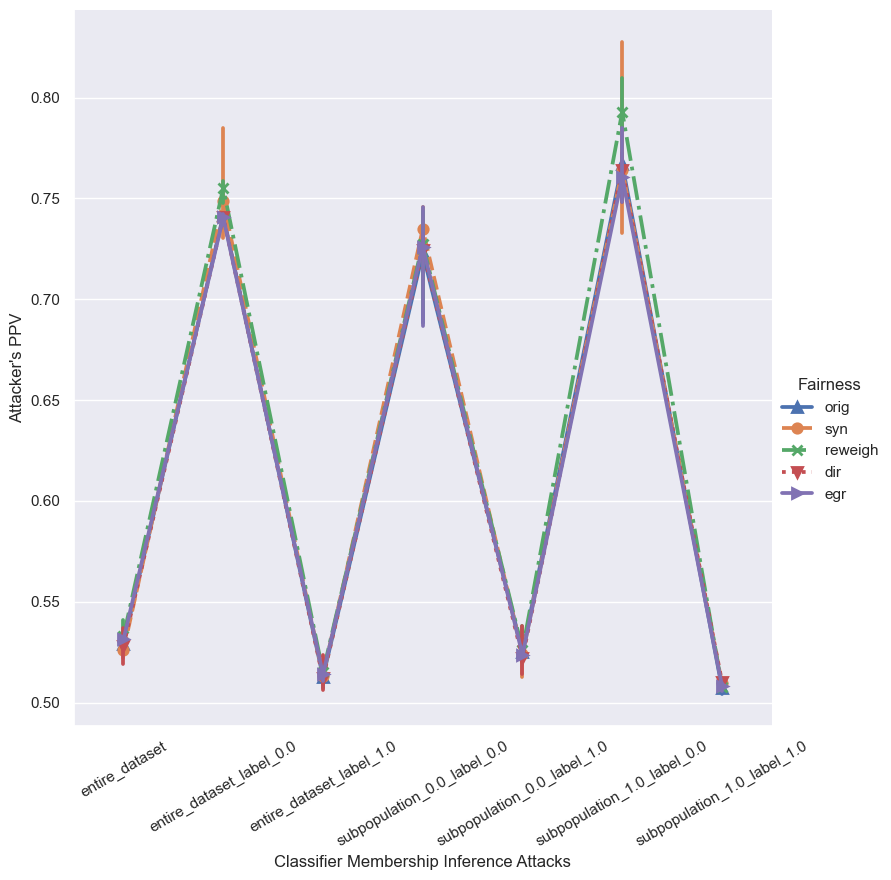

In [62]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [63]:
import pandas as pd

In [64]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

decile3  decile1  race  cluster  lsat  ugpa  dob_yr  fulltime  fam_inc  \
0         10.0     10.0   7.0      1.0  44.0   3.5    69.0       1.0      5.0   
1          4.0      5.0   7.0      2.0  29.0   3.5    69.0       1.0      4.0   
2          7.0      8.0   7.0      1.0  37.0   3.4    68.0       1.0      3.0   
3          7.0      8.0   7.0      1.0  43.0   3.3    67.0       1.0      4.0   
4          2.0      3.0   7.0      4.0  41.0   3.3    64.0       1.0      4.0   
...        ...      ...   ...      ...   ...   ...     ...       ...      ...   
20793      8.0      9.0   7.0      5.0  42.0   3.0    67.0       1.0      4.0   
20794      9.0      4.0   7.0      3.0  29.5   3.5    68.0       1.0      4.0   
20795      1.0      1.0   3.0      3.0  33.0   3.1    69.0       1.0      3.0   
20796      5.0      4.0   7.0      3.0  32.0   3.0    67.0       0.0      3.0   
20797      3.0      9.0   8.0      4.0  36.0   3.2    67.0       1.0      3.0   

        age  gender  race2  other  asian  black  hisp  tier  indxgrp  \
0     -62.0     0.0    1.0    0.0    0.0    0.0   0.0   4.0      6.0   
1     -62.0     0.0    1.0    0.0    0.0    0.0   0.0   2.0      5.0   
2     -61.0     1.0    1.0    0.0    0.0    0.0   0.0   4.0      6.0   
3     -60.0     0.0    1.0    0.0    0.0    0.0   0.0   4.0      6.0   
4     -57.0     0.0    1.0    0.0    0.0    0.0   0.0   5.0      6.0   
...     ...     ...    ...    ...    ...    ...   ...   ...      ...   
20793 -60.0     1.0    1.0    0.0    0.0    0.0   0.0   6.0      6.0   
20794 -61.0     1.0    1.0    0.0    0.0    0.0   0.0   3.0      5.0   
20795 -62.0     1.0    0.0    0.0    0.0    1.0   0.0   3.0      5.0   
20796 -65.0     1.0    1.0    0.0    0.0    0.0   0.0   3.0      5.0   
20797 -60.0     1.0    2.0    1.0    0.0    0.0   0.0   5.0      6.0   

       indxgrp2  labels  
0           8.0     1.0  
1           5.0     1.0  
2           7.0     1.0  
3           8.0     1.0  
4           7.0     1.0  
...         ...     ...  
20793       7.0     1.0  
20794       5.0     1.0  
20795       5.0     0.0  
20796       5.0     1.0  
20797       6.0     1.0  

[20798 rows x 20 columns]

In [65]:
df[["age", "labels"]].value_counts(normalize=True)

age    labels
-62.0  1.0       0.245841
-61.0  1.0       0.171603
-60.0  1.0       0.100635
-59.0  1.0       0.069478
-58.0  1.0       0.048418
                   ...   
-24.0  1.0       0.000048
-26.0  1.0       0.000048
-28.0  0.0       0.000048
-33.0  0.0       0.000048
-3.0   1.0       0.000048
Name: proportion, Length: 95, dtype: float64

In [66]:
df.drop_duplicates()

decile3  decile1  race  cluster  lsat  ugpa  dob_yr  fulltime  fam_inc  \
0         10.0     10.0   7.0      1.0  44.0   3.5    69.0       1.0      5.0   
1          4.0      5.0   7.0      2.0  29.0   3.5    69.0       1.0      4.0   
2          7.0      8.0   7.0      1.0  37.0   3.4    68.0       1.0      3.0   
3          7.0      8.0   7.0      1.0  43.0   3.3    67.0       1.0      4.0   
4          2.0      3.0   7.0      4.0  41.0   3.3    64.0       1.0      4.0   
...        ...      ...   ...      ...   ...   ...     ...       ...      ...   
20793      8.0      9.0   7.0      5.0  42.0   3.0    67.0       1.0      4.0   
20794      9.0      4.0   7.0      3.0  29.5   3.5    68.0       1.0      4.0   
20795      1.0      1.0   3.0      3.0  33.0   3.1    69.0       1.0      3.0   
20796      5.0      4.0   7.0      3.0  32.0   3.0    67.0       0.0      3.0   
20797      3.0      9.0   8.0      4.0  36.0   3.2    67.0       1.0      3.0   

        age  gender  race2  other  asian  black  hisp  tier  indxgrp  \
0     -62.0     0.0    1.0    0.0    0.0    0.0   0.0   4.0      6.0   
1     -62.0     0.0    1.0    0.0    0.0    0.0   0.0   2.0      5.0   
2     -61.0     1.0    1.0    0.0    0.0    0.0   0.0   4.0      6.0   
3     -60.0     0.0    1.0    0.0    0.0    0.0   0.0   4.0      6.0   
4     -57.0     0.0    1.0    0.0    0.0    0.0   0.0   5.0      6.0   
...     ...     ...    ...    ...    ...    ...   ...   ...      ...   
20793 -60.0     1.0    1.0    0.0    0.0    0.0   0.0   6.0      6.0   
20794 -61.0     1.0    1.0    0.0    0.0    0.0   0.0   3.0      5.0   
20795 -62.0     1.0    0.0    0.0    0.0    1.0   0.0   3.0      5.0   
20796 -65.0     1.0    1.0    0.0    0.0    0.0   0.0   3.0      5.0   
20797 -60.0     1.0    2.0    1.0    0.0    0.0   0.0   5.0      6.0   

       indxgrp2  labels  
0           8.0     1.0  
1           5.0     1.0  
2           7.0     1.0  
3           8.0     1.0  
4           7.0     1.0  
...         ...     ...  
20793       7.0     1.0  
20794       5.0     1.0  
20795       5.0     0.0  
20796       5.0     1.0  
20797       6.0     1.0  

[20679 rows x 20 columns]